# Inference Test

In [1]:
import argparse
import os
import sys

import torch
import torch.optim as optim

import neptune
from neptune_pytorch import NeptuneLogger
from neptune.utils import stringify_unsupported

import albumentations as A
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from hover_net.dataloader.dataset import get_dataloader
from hover_net.models import HoVerNetExt
from hover_net.process import proc_valid_step_output, train_step, valid_step
from hover_net.tools.utils import (dump_yaml, read_yaml,
                                   update_accumulated_output)

In [2]:
config = read_yaml('../configs/config.yaml')

model = HoVerNetExt(
    backbone_name=config["MODEL"]["BACKBONE"],
    pretrained_backbone=config["MODEL"]["PRETRAINED"],
    num_types=config["MODEL"]["NUM_TYPES"]
)
model.load_state_dict(torch.load('../latest.pth', weights_only=True))
model.eval()

c:\home\university\7-semester\deep-learning-project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\home\university\7-semester\deep-learning-project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


HoVerNetExt(
  (backbone): ResNextExt(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

In [3]:
IMAGE_DIR = '../data/01_training_dataset_tif_ROIs'

transform = A.Compose([
    A.RandomCrop(width=256, height=256)
])

images = os.listdir(IMAGE_DIR)

for image in images:
    img = Image.open(os.path.join(IMAGE_DIR, image))
    img = transform(image=np.array(img))['image']
    img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()
    img_tensor = img_tensor[:, 1:, :, :]
    print(img_tensor.shape)
    out = model(img_tensor)
    break

torch.Size([1, 3, 256, 256])


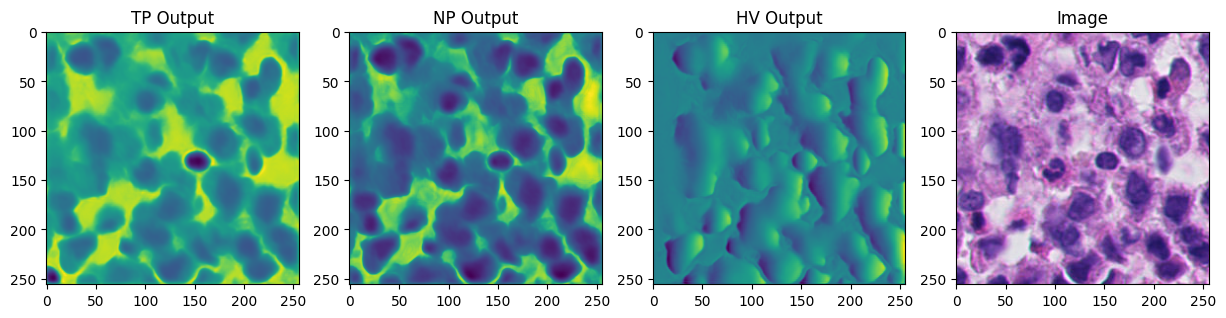

In [4]:
# Plot the output tensors
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot tp tensor
axes[0].imshow(out['tp'].detach().numpy()[0, 0, :, :], cmap='viridis')
axes[0].set_title('TP Output')

# Plot np tensor
axes[1].imshow(out['np'].detach().numpy()[0, 0, :, :], cmap='viridis')
axes[1].set_title('NP Output')

# Plot hv tensor
axes[2].imshow(out['hv'].detach().numpy()[0, 0, :, :], cmap='viridis')
axes[2].set_title('HV Output')

axes[3].imshow(img, cmap='viridis')
axes[3].set_title('Image')

plt.show()

In [5]:
from hover_net.dataloader import get_dataloader
from hover_net.postprocess import process
from hover_net.process import infer_step, visualize_instances_dict
from hover_net.tools.api import parse_single_instance

def infer_one_image(
    model,
    nr_types=3,
    device="cuda",
    show=False
):
    test_dataloader = get_dataloader(
        dataset_type="puma",
        image_path=config["DATA"]["IMAGE_PATH"],
        geojson_path=config["DATA"]["GEOJSON_PATH"],
        with_type=True,
        input_shape=(
            config["DATA"]["PATCH_SIZE"],
            config["DATA"]["PATCH_SIZE"]
        ),
        mask_shape=(
            config["DATA"]["PATCH_SIZE"],
            config["DATA"]["PATCH_SIZE"]
        ),
        batch_size=1,
        run_mode="test",
    )

    detection_list = []
    segmentation_list = []
    for step_idx, data in enumerate(test_dataloader):
        assert data.shape[0] == 1

        test_result_output = infer_step(
            batch_data=data, model=model, device=device
        )
        image_id = 0
        for curr_image_idx in range(len(test_result_output)):
            pred_inst, inst_info_dict = process(
                test_result_output[curr_image_idx],
                nr_types=nr_types,
                return_centroids=True
            )

            for single_inst_info in inst_info_dict.values():
                detection_dict, segmentation_dict = parse_single_instance(
                    image_id, single_inst_info
                )
                detection_list.append(detection_dict)
                segmentation_list.append(segmentation_dict)

            if show:
                src_image = data[0].numpy()
                type_info_dict = {
                    "0": ["nolabe", [0, 0, 0]],
                    "1": ["neopla", [255, 0, 0]],
                    "2": ["inflam", [0, 255, 0]],
                    "3": ["connec", [0, 0, 255]],
                    "4": ["necros", [255, 255, 0]],
                    "5": ["no-neo", [255, 165, 0]]
                }
                type_info_dict = {
                    int(k): (
                        v[0], tuple(v[1])
                    ) for k, v in type_info_dict.items()
                }
                overlay_kwargs = {
                    "draw_dot": True,
                    "type_colour": type_info_dict,
                    "line_thickness": 2,
                }
                overlaid_img = visualize_instances_dict(
                    src_image.copy(), inst_info_dict, **overlay_kwargs
                )
                plt.imshow(overlaid_img)
                plt.axis("off")
                plt.show()

    return inst_info_dict, detection_list, segmentation_list


In [6]:
IMAGE_DIR = '../data/01_training_dataset_tif_ROIs'

transform = A.Compose([
    A.RandomCrop(width=256, height=256)
])

images = os.listdir(IMAGE_DIR)

for image in images:
    img = Image.open(os.path.join(IMAGE_DIR, image))
    img = transform(image=np.array(img))['image']
    img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()
    img_tensor = img_tensor[:, 1:, :, :]
    print(img_tensor.shape)
    # out = model(img_tensor)
    break

"""
    image_path,
    model,
    nr_types=3,
    input_size=(512, 512),
    device="cuda",
    show=False
"""

model.to('cuda')
infer_one_image(os.path.join(IMAGE_DIR, images[0]), model, nr_types=4, input_size=(256, 256), show=True)

torch.Size([1, 3, 256, 256])


TypeError: infer_one_image() got multiple values for argument 'nr_types'

../data/01_training_dataset_tif_ROIs
Number of primary ROIs: 103
Number of metastatic ROIs: 103


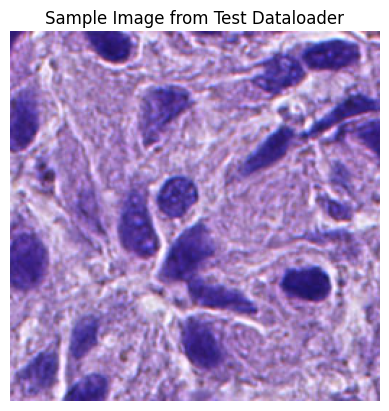

AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
from hover_net.dataloader import get_dataloader
from hover_net.postprocess import process
from hover_net.process import infer_step, visualize_instances_dict
from hover_net.tools.api import parse_single_instance

IMAGE_DIR = '../data/01_training_dataset_tif_ROIs'
GEOJSON_DIR = '../data/01_training_dataset_geojson_nuclei'

nr_types = 3
device = "cuda"
show = True

test_dataloader = get_dataloader(
    dataset_type="puma",
    image_path=IMAGE_DIR,
    geojson_path=GEOJSON_DIR,
    with_type=True,
    input_shape=(
        config["DATA"]["PATCH_SIZE"],
        config["DATA"]["PATCH_SIZE"]
    ),
    mask_shape=(
        config["DATA"]["PATCH_SIZE"],
        config["DATA"]["PATCH_SIZE"]
    ),
    batch_size=1,
    run_mode="test",
)

# Plot an image from the test_dataloader
data_iter = iter(test_dataloader)
sample_data = next(data_iter)
sample_image = sample_data['img'][0].numpy()

plt.imshow(sample_image)
plt.title('Sample Image from Test Dataloader')
plt.axis('off')
plt.show()

detection_list = []
segmentation_list = []
for step_idx, data in enumerate(test_dataloader):
    data = data['img']
    assert data.shape[0] == 1

    test_result_output = infer_step(
        batch_data=data, model=model, device=device
    )
    image_id = 0
    for curr_image_idx in range(len(test_result_output)):
        pred_inst, inst_info_dict = process(
            test_result_output[curr_image_idx],
            nr_types=nr_types,
            return_centroids=True
        )

        for single_inst_info in inst_info_dict.values():
            detection_dict, segmentation_dict = parse_single_instance(
                image_id, single_inst_info
            )
            detection_list.append(detection_dict)
            segmentation_list.append(segmentation_dict)

        if show:
            src_image = data[0].numpy()
            type_info_dict = {
                "0": ["nolabe", [0, 0, 0]],
                "1": ["neopla", [255, 0, 0]],
                "2": ["inflam", [0, 255, 0]],
                "3": ["connec", [0, 0, 255]],
                "4": ["necros", [255, 255, 0]],
                "5": ["no-neo", [255, 165, 0]]
            }
            type_info_dict = {
                int(k): (
                    v[0], tuple(v[1])
                ) for k, v in type_info_dict.items()
            }
            overlay_kwargs = {
                "draw_dot": True,
                "type_colour": type_info_dict,
                "line_thickness": 2,
            }
            overlaid_img = visualize_instances_dict(
                src_image.copy(), inst_info_dict, **overlay_kwargs
            )
            plt.imshow(overlaid_img)
            plt.axis("off")
            plt.show()